In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib
import warnings

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import spearmanr
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor, IsolationForest
from sklearn.base import clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.covariance import EllipticEnvelope
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
    calc_double_sharpe,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

def my_cache(func):
    def func2(*args, **kwargs):
        mem = get_joblib_memory()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return mem.cache(func)(*args, **kwargs)
    return func2

@my_cache
def fit_model_cached(model, *args, **kwargs):
    model = clone(model)
    model.fit(*args, **kwargs)
    return model

# unbiased_rank = my_cache(unbiased_rank)
# cross_val_predict = my_cache(cross_val_predict)

model_name = '20230415_stock'

In [2]:
provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'stock_ohlcv',
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    def func1(df):
        df = df.set_index(['timestamp', 'symbol']).sort_index()
        df = df.loc[~df.index.duplicated()]
        
        df = df.loc[df['op'] > 0]
        df = df.loc[df['hi'] > 0]
        df = df.loc[df['lo'] > 0]
        df = df.loc[df['cl'] > 0]
        df = df.loc[df['adj_cl'] > 0]
        df = df.loc[df['volume'] > 0]
        
        prev_cl = df.groupby('symbol')['cl'].shift(1)
        invalid_symbols = df.loc[np.abs(np.log(df['cl'] / prev_cl)) > np.log(2)].index.get_level_values('symbol').unique()
        print('invalid_symbols', invalid_symbols)
        df = df.loc[~df.index.get_level_values('symbol').isin(invalid_symbols)]

        prev_cl = df.groupby('symbol')['adj_cl'].shift(1)
        invalid_symbols = df.loc[np.abs(np.log(df['adj_cl'] / prev_cl)) > np.log(2)].index.get_level_values('symbol').unique()
        print('invalid_symbols', invalid_symbols)
        df = df.loc[~df.index.get_level_values('symbol').isin(invalid_symbols)]
        
        return df
    
    df = func1(dfs[0])
    
    return df

df = merge_data(dfs)

df = df.dropna()
df.to_pickle('/tmp/df_stock.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,adj_cl,volume,dividends,splits,capital_gains,symbol_name,industry_code
0,2023-04-14 00:00:00+00:00,9115.T,639.000000,639.000000,629.000000,629.000000,629.000000,109800.0,0.0,0.0,0.0,明治海運,5100
1,2022-07-12 00:00:00+00:00,1380.T,1069.000000,1069.000000,1069.000000,1069.000000,1059.000000,0.0,0.0,0.0,0.0,秋川牧園,50
2,2016-04-25 00:00:00+00:00,9104.T,943.333313,943.333313,903.333313,906.666687,579.609131,8146800.0,0.0,0.0,0.0,商船三井,5100
3,2013-01-16 00:00:00+00:00,1515.T,2015.000000,2015.000000,1980.000000,1985.000000,1594.031372,18000.0,0.0,0.0,0.0,日鉄鉱業,1050
4,2013-01-11 00:00:00+00:00,1301.T,1960.000000,1960.000000,1900.000000,1940.000000,1595.922729,39200.0,0.0,0.0,0.0,極洋,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16613086,2019-12-02 00:00:00+00:00,2801.T,5530.000000,5620.000000,5530.000000,5600.000000,5450.892090,369800.0,0.0,0.0,0.0,キッコーマン,3050
16613087,2019-12-24 00:00:00+00:00,2872.T,1128.333374,1131.666626,1100.000000,1126.666626,1071.538208,3600.0,0.0,0.0,0.0,セイヒョー,3050
16613088,2019-12-24 00:00:00+00:00,2875.T,4720.000000,4745.000000,4705.000000,4735.000000,4470.708984,97400.0,0.0,0.0,0.0,東洋水産,3050
16613089,2019-12-10 00:00:00+00:00,2924.T,786.000000,786.000000,773.000000,773.000000,706.117737,5800.0,0.0,0.0,0.0,イフジ産業,3050


invalid_symbols Index(['6323.T', '6324.T', '7610.T', '6481.T', '9478.T', '4837.T', '7618.T',
       '5721.T', '4335.T', '4288.T',
       ...
       '6626.T', '6954.T', '7134.T', '7794.T', '8035.T', '9229.T', '9338.T',
       '9733.T', '9927.T', '9318.T'],
      dtype='object', name='symbol', length=238)
invalid_symbols Index(['9020.T', '9432.T', '9436.T', '7518.T', '9433.T', '4327.T', '8898.T',
       '9613.T', '8904.T', '4832.T', '7647.T', '9444.T', '4755.T', '4287.T',
       '8903.T', '9861.T', '7604.T', '4355.T', '4722.T', '4784.T', '8912.T',
       '6668.T', '4973.T', '8798.T', '4680.T', '8698.T', '7268.T', '6677.T',
       '7615.T', '4304.T', '4676.T', '4839.T', '6466.T', '8306.T', '9409.T',
       '6778.T', '4324.T', '6648.T', '8940.T', '3835.T', '8308.T', '8938.T',
       '9445.T', '8985.T', '8975.T', '8963.T', '3839.T', '4290.T', '6157.T',
       '7749.T', '9022.T', '3836.T', '4824.T', '9381.T', '8697.T', '8957.T',
       '3841.T', '3851.T', '5742.T', '8732.T', '4829.T', '4809.

op            hi            lo  \
timestamp                 symbol                                             
1999-05-06 00:00:00+00:00 6806.T  10571.428711  10666.666992  10180.952148   
                          7203.T    698.000000    722.000000    690.000000   
                          7752.T   1170.000000   1190.000000   1160.000000   
1999-05-07 00:00:00+00:00 6806.T  10371.428711  10371.428711   9714.286133   
                          7203.T    718.000000    720.000000    690.000000   
...                                        ...           ...           ...   
2023-04-14 00:00:00+00:00 9993.T   1315.000000   1328.000000   1305.000000   
                          9994.T   2606.000000   2625.000000   2601.000000   
                          9995.T    413.000000    413.000000    410.000000   
                          9996.T   1216.000000   1219.000000   1210.000000   
                          9997.T    710.000000    711.000000    705.000000   

                                            cl       adj_cl      volume  \
timestamp                 symbol                                          
1999-05-06 00:00:00+00:00 6806.T  10380.952148  7998.520020     65310.0   
                          7203.T    722.000000    75.560051  15575000.0   
                          7752.T   1170.000000   767.880615   1608000.0   
1999-05-07 00:00:00+00:00 6806.T  10238.095703  7888.444824    122010.0   
                          7203.T    696.000000    72.839073  15165000.0   
...                                        ...          ...         ...   
2023-04-14 00:00:00+00:00 9993.T   1326.000000  1326.000000      7800.0   
                          9994.T   2621.000000  2621.000000     15600.0   
                          9995.T    410.000000   410.000000     72000.0   
                          9996.T   1210.000000  1210.000000      3400.0   
                          9997.T    707.000000   707.000000    102400.0   

                                  dividends  splits  capital_gains  \
timestamp                 symbol                                     
1999-05-06 00:00:00+00:00 6806.T        0.0     0.0            0.0   
                          7203.T        0.0     0.0            0.0   
                          7752.T        0.0     0.0            0.0   
1999-05-07 00:00:00+00:00 6806.T        0.0     0.0            0.0   
                          7203.T        0.0     0.0            0.0   
...                                     ...     ...            ...   
2023-04-14 00:00:00+00:00 9993.T        0.0     0.0            0.0   
                          9994.T        0.0     0.0            0.0   
                          9995.T        0.0     0.0            0.0   
                          9996.T        0.0     0.0            0.0   
                          9997.T        0.0     0.0            0.0   

                                 symbol_name  industry_code  
timestamp                 symbol                             
1999-05-06 00:00:00+00:00 6806.T       ヒロセ電機           3650  
                          7203.T      トヨタ自動車           3700  
                          7752.T         リコー           3650  
1999-05-07 00:00:00+00:00 6806.T       ヒロセ電機           3650  
                          7203.T      トヨタ自動車           3700  
...                                      ...            ...  
2023-04-14 00:00:00+00:00 9993.T        ヤマザワ           6100  
                          9994.T         やまや           6100  
                          9995.T       グローセル           6050  
                          9996.T       サトー商会           6050  
                          9997.T        ベルーナ           6100  

[14101835 rows x 11 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype
from joblib import Parallel, delayed

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

# @my_cache
def beta_mean(ser):
    # broadcast btc value
    # idx = df.index.to_frame()
    # idx['symbol'] = 'BTC'
    # idx = pd.MultiIndex.from_frame(idx)
    # return pd.Series(df.loc[idx, col].values, index=df.index)
    # return ser.groupby('timestamp').transform('mean')
    return ser.groupby('timestamp').transform('mean')

def calc_features(df):
    df_features = do_calc_features(df[[
        'op', 'hi', 'lo', 'cl', 'volume', 'dividends',
    ]])
    return pd.concat([df, df_features[get_feature_columns(df_features)]], axis=1)

@my_cache
def do_calc_features(df):
    df = df.copy()
    
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(delayed(calc_features_single)(df_symbol))
        # dfs.append(calc_features_single(df_symbol))
    dfs = Parallel(n_jobs=-1)(dfs)
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    # df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
        
    dfs_parallel = []
    def func_parallel1(col):
        feature_mean = beta_mean(df[col])
        return [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    for col in get_feature_columns(df):
        dfs_parallel.append(delayed(func_parallel1)(col))
    for res in Parallel(n_jobs=-1)(dfs_parallel):
        dfs += res
    
    df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    df['feature_op'] = np.log(df['op'] / df['cl'])
    df['feature_hi'] = np.log(df['hi'] / df['cl'])
    df['feature_lo'] = np.log(df['lo'] / df['cl'])
    df['feature_hi_op'] = np.log(df['hi'] / df['op'])
    df['feature_lo_op'] = np.log(df['lo'] / df['op'])
    df['feature_hi_lo'] = np.log(df['hi'] / df['lo'])
    
    for i in range(1):
        for col1 in ['op', 'hi', 'lo', 'cl']:
            for col2 in ['op', 'hi', 'lo', 'cl']:
                df['feature_{}_prev_{}_{}'.format(col1, col2, i)] = np.log(df[col2].shift(1) / df[col1]).shift(i).fillna(0)
    
    df['feature_dividends'] = df['dividends']
    df.loc[df['feature_dividends'] == 0, 'feature_dividends'] = np.nan
    df['feature_dividends'] = df['feature_dividends'].ffill(limit=240).fillna(0) / df['cl']
    
    # df['feature_op_cl_mom'] = np.log(df['op'] / df['cl']).rolling(20, 1).mean()
    # df['feature_op_cl_sharpe'] = (np.log(df['op'] / df['cl']).rolling(20, 10).mean() / np.log(df['op'] / df['cl']).rolling(20, 10).std()).fillna(0)
    # df['feature_op_cl_rsi'] = (np.log(df['op'] / df['cl']).rolling(20, 1).mean() / np.log(df['op'] / df['cl']).abs().rolling(20, 1).mean()).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    for t_center in [5, 20, 60]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NatFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None, random_state=None, target='uniform'):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio
        self.random_state = random_state
        self.target = target

    def fit(self, X, y=None):
        X = self._validate_data(X)
        
        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        self.selected_features_ = nat_calc_features(self.estimator, remove_count, X, self.random_state, self.target)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


@my_cache
def nat_calc_features(model, remove_count, X, random_state, target):
    model = clone(model)
    rs = np.random.RandomState(random_state)
    if target == 'time':
        model.fit(X, np.arange(X.shape[0]))
    elif target == 'normal':
        model.fit(X, rs.normal(0, 1, size=X.shape[0]))
    elif target == 'uniform':
        model.fit(X, rs.uniform(0, 1, size=X.shape[0])) # good
    elif target == 'binary':
        model.fit(X, rs.randint(0, 2, size=X.shape[0]))
    else:
        raise Exception('not implemented')
    importances = model.feature_importances_

    features = list(range(X.shape[1]))
    feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
    feature_imp = feature_imp.sort_values('value')

    for i in range(X.shape[1] - remove_count, X.shape[1]):
        features.remove(int(feature_imp['feature'].iloc[i]))

    return np.array(features)

In [5]:
def feature_selector_null_imp_ratio(X, y):
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        extra_trees=True,
        # colsample_bytree=0.9,
        colsample_bytree=0.03,
        subsample=0.5,
        subsample_freq=1,
        # lambda_l2=1e1,
        random_state=1,
        n_jobs=-1,
        importance_type='gain',
    )
    model.fit(X, y)
    imp = model.feature_importances_.copy()
    rs = np.random.RandomState(1)
    model.fit(X, rs.permutation(y))
    imp_noise = model.feature_importances_.copy()
    return imp / imp_noise

In [48]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV
import catboost

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        def merge_data2(dfs):
            df = merge_data(dfs)
            df = df.loc[df.index.get_level_values('symbol').isin(self.symbols)]
            return df
        
        self.merge_data = merge_data2
        
        self.max_data_sec = 2 * 24 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.mode = 'stock'

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df['ret_train'])
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df['ret_night_mean'] = beta_mean(df['ret_night'])
        df['ret_night_beta'] = df['ret_night'] - df['ret_night_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        # df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        y = df['ret_beta']
        y_night = df['ret_night_beta']
        # y = np.sign(y) * np.log(1 + np.abs(y))
        # y = np.sign(y) * np.log(1 + 10 * np.abs(y))
        
        # df['ret_beta_abs'] = df['ret_beta'].abs()
        # df['ret_beta_abs_sum'] = df.groupby('timestamp')['ret_beta_abs'].transform('sum')
        # y = df['ret_beta'] / (1e-37 + df['ret_beta_abs_sum'])
        
        # self._model.fit(df[features], y)
        # return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        # self._model.fit(df[features], np.sign(y), sample_weight=np.abs(y))
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            # extra_trees=True,
            colsample_bytree=0.5,
            # colsample_bytree=0.03,
            subsample=0.5,
            subsample_freq=1,
            # lambda_l2=1e1,
            random_state=1,
            n_jobs=-1,
        )
        model = self._model
        # self._model = StackingRegressor([ # good return
        #     ('lgbm', self._model),
        #     # ('et', et),
        #     # ('rf', rf),
        # ], final_estimator=clone(self._model), n_jobs=1, passthrough=True)
        self._model = BaggingRegressor(
            self._model,
            # n_estimators=5,
            n_estimators=10,
            random_state=1,
        )
        
#         self._model = VotingRegressor([
#             ('et', self._model),
#             ('lgbm', BaggingRegressor(
#                 lgb.LGBMRegressor(
#                     n_estimators=1000,
#                     learning_rate=0.01,
#                     # extra_trees=True,
#                     # colsample_bytree=0.9,
#                     colsample_bytree=0.03,
#                     subsample=0.5,
#                     subsample_freq=1,
#                     # lambda_l2=1e1,
#                     random_state=2,
#                     n_jobs=-1,
#                 ),
#                 n_estimators=5,
#                 random_state=2,
#             ))
#         ])
        
        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        self._model = Pipeline([
            # ('nat1', NatFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            #     random_state=1,
            # )),
            # ('nat2', NatFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            #     random_state=2,
            # )),
            # ('nat3', NatFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            #     random_state=3,
            # )),
            # ('nat4', NatFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            #     random_state=4,
            # )),
            # ('remove_nonstationary_dcor', SelectPercentile(
            #     score_func=feature_selector_dcor_t,
            #     percentile=50,
            # )),
            # ('select_imp', SelectPercentile(
            #     score_func=feature_selector_null_imp_ratio,
            #     percentile=70,
            # )),
            ('model', self._model)
        ])
        
        self._model_night = clone(self._model)
        
        self._model = fit_model_cached(self._model, df[features], np.sign(y), model__sample_weight=np.abs(y))
        # self._model_night = fit_model_cached(self._model_night, df[features], np.sign(y_night), model__sample_weight=np.abs(y_night))
        
        # df_imp = pd.Series(model.feature_importances_.copy())
        # display()
        
        # self._model.fit(df[features], np.sign(y), model__sample_weight=np.abs(y))
        # self._model.fit(df[features], np.sign(y) * np.abs(y) ** 0.5, model__sample_weight=np.abs(y) ** 0.5)
        # self._model.fit(df[features], np.sign(y) / (1e-5 + np.abs(y)), model__sample_weight=np.abs(y) ** 2)
        # self._model.fit(df[features], np.sign(y) / (1e-7 + np.abs(y) ** 2), model__sample_weight=np.abs(y) ** 3)
        # return self._model.fit(df[features], np.sign(df['ret']), model__sample_weight=np.abs(df['ret']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['position_op'] = 0.0
        df['position_cl'] = 0.0
        
        for i in range(0, 1):
            if i == 0:
                y_pred = self._model.predict(df[features])
            else:
                y_pred = self._model_night.predict(df[features])

            # df['position'] = np.sign(y_pred)
            df['position'] = y_pred
            # idx_btc = df.index.get_level_values('symbol') == 'BTC'
            # df.loc[idx_btc, 'position'] = 0
            # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5

            df['pos_abs'] = df['position'].abs()
            # df['position'] *= uniform_rank(df.groupby('timestamp')['pos_abs']) > 0.95
            # df['position'] *= uniform_rank(df.groupby('timestamp')['pos_abs']) ** 10
            df['position'] *= np.exp((uniform_rank(df.groupby('timestamp')['pos_abs']) - 1) * 60)
            # df['position'] = np.sign(df['position']) * np.exp((uniform_rank(df.groupby('timestamp')['pos_abs']) - 1) * 80)
            # df['position'] *= df['pos_abs'] ** 1
            # df['position'] *= df['position'].abs() > 0.002

            df['position_beta'] = df['position'] * df['beta']
            df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')

            normalize_position(df)

            if i == 0:
                df['position_op'] = df['position'] # * 0.0
            else:
                df['position_cl'] = df['position']
        
        return df[['position_op', 'position_cl']]
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        df['beta'] = 1.0
        
        # df['feature_vola'] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(24).std() / x).fillna(0)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        df['feature_industry_code'] = df['industry_code'].astype(int)
        
        t = df.index.get_level_values('timestamp')
        df['feature_multiple_of_5'] = t.day // 5
        df['feature_day_of_year'] = 31 * t.month + t.day
        df['feature_day_of_week'] = t.day_of_week
        
        return df


class SignRegressor(BaseEstimator):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None):
        self.model_ = clone(self.model)
        self.model_.fit(X, np.sign(y), sample_weight=np.abs(y))
        return self
    
    def predict(self, X):
        return self.model_.predict(X)


In [49]:
from src.ml_utils import _calc_cv_indicies, calc_sharpe, calc_double_sharpe, calc_max_dd

def calc_position_cv_stock(model, df, cv=5, causal=False):
    df_output = df.copy()
    cv_indicies = _calc_cv_indicies(df, cv, causal=causal)
    for train_idx, val_idx in cv_indicies:
        model.fit(df.loc[train_idx])
        res = model.predict(df.loc[val_idx])
        for col in res.columns:
            df_output.loc[val_idx, col] = res[col]
    return df_output

def visualize_result_stock(df, execution_cost=0.001):
    df = df.copy()

    # calc return
    df["ret_pos"] = df["ret"] * df["position_op"] + df["ret_night"] * df["position_cl"]
    df["position_cl_prev"] = df.groupby(["symbol"])["position_cl"].shift(1).fillna(0)
    df["cost"] = ((df["position_op"] - df["position_cl_prev"]).abs() + (df["position_cl"] - df["position_op"]).abs()) * execution_cost
    df["ret_pos_cost"] = df["ret_pos"] - df["cost"]

    # print statistics
    for with_cost in [False, True]:
        if with_cost:
            print("return with cost statistics")
            x = df.groupby("timestamp")["ret_pos_cost"].sum()
        else:
            print("return without cost statistics")
            x = df.groupby("timestamp")["ret_pos"].sum()

        print("mean {}".format(np.mean(x)))
        print("std {}".format(np.std(x)))
        print("sharpe {}".format(calc_sharpe(x)))
        print("double sharpe {}".format(calc_double_sharpe(x, 24 * 30)))
        print("max drawdown {}".format(calc_max_dd(x.cumsum())))
        print("min {}".format(np.min(x)))
        print("min sharpe {}".format(-np.mean(x) / np.min(x)))

    # plot ret
    for symbol, df_symbol in df.groupby("symbol"):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["ret_pos"].cumsum().plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("return without cost by symbol")
    plt.show()
    for symbol, df_symbol in df.groupby("symbol"):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["ret_pos_cost"].cumsum().plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("return with cost by symbol")
    plt.show()

    # plot position
    for symbol, df_symbol in df.groupby("symbol"):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["position_op"].plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("position by symbol")
    plt.show()

    # plot total ret
    df.groupby("timestamp")["ret_pos"].sum().cumsum().plot(label="ret without cost")
    df.groupby("timestamp")["ret_pos_cost"].sum().cumsum().plot(label="ret with cost")
    df.groupby("timestamp")["cost"].sum().cumsum().plot(label="cost")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("total return")
    plt.show()


,ret,ret_night
count,695957.000000,6.959570e+05
mean,-0.000223,7.613351e-04
std,0.018681,1.527218e-02
min,-0.274171,-4.992224e-01
25%,-0.009157,-5.771880e-03
50%,0.000000,1.694636e-07
75%,0.008460,7.252252e-03
max,0.387097,5.787034e-01


fit df.shape (568434, 401)
fit df.shape (562174, 401)
fit df.shape (557401, 401)
fit df.shape (551423, 401)
fit df.shape (543534, 401)
return without cost statistics
mean 0.00223392101600827
std 0.012516636695135192
sharpe 0.17847614102888537
double sharpe 4.329734078478202
max drawdown 0.32515143580212946
min -0.07657440895723924
min sharpe 0.029173206119759126
return with cost statistics
mean 0.00123392101600827
std 0.012516636695135194
sharpe 0.0985824743549403
double sharpe 2.122904204589574
max drawdown 0.3859015161261663
min -0.07757440895723923
min sharpe 0.015906289620439586


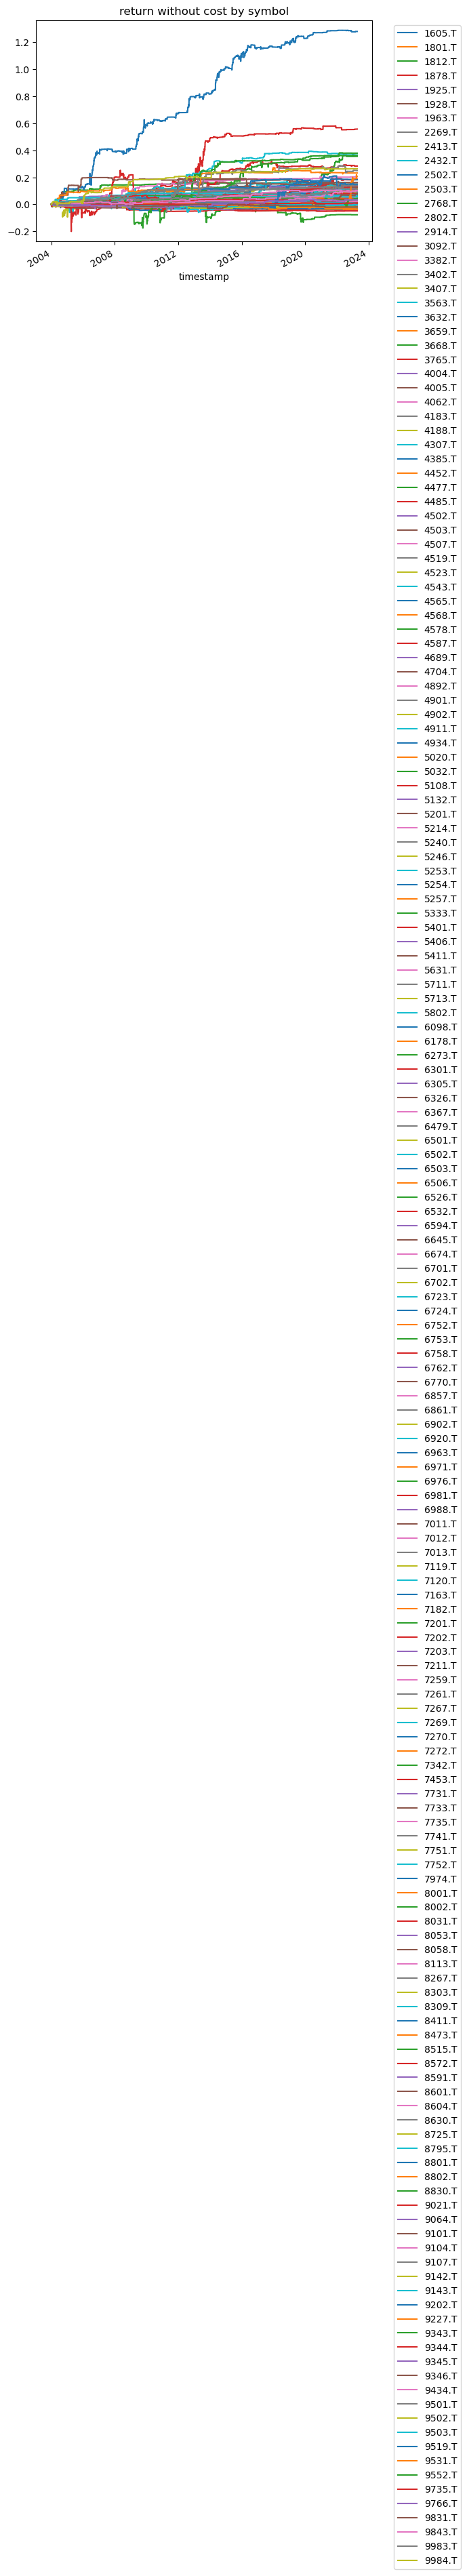

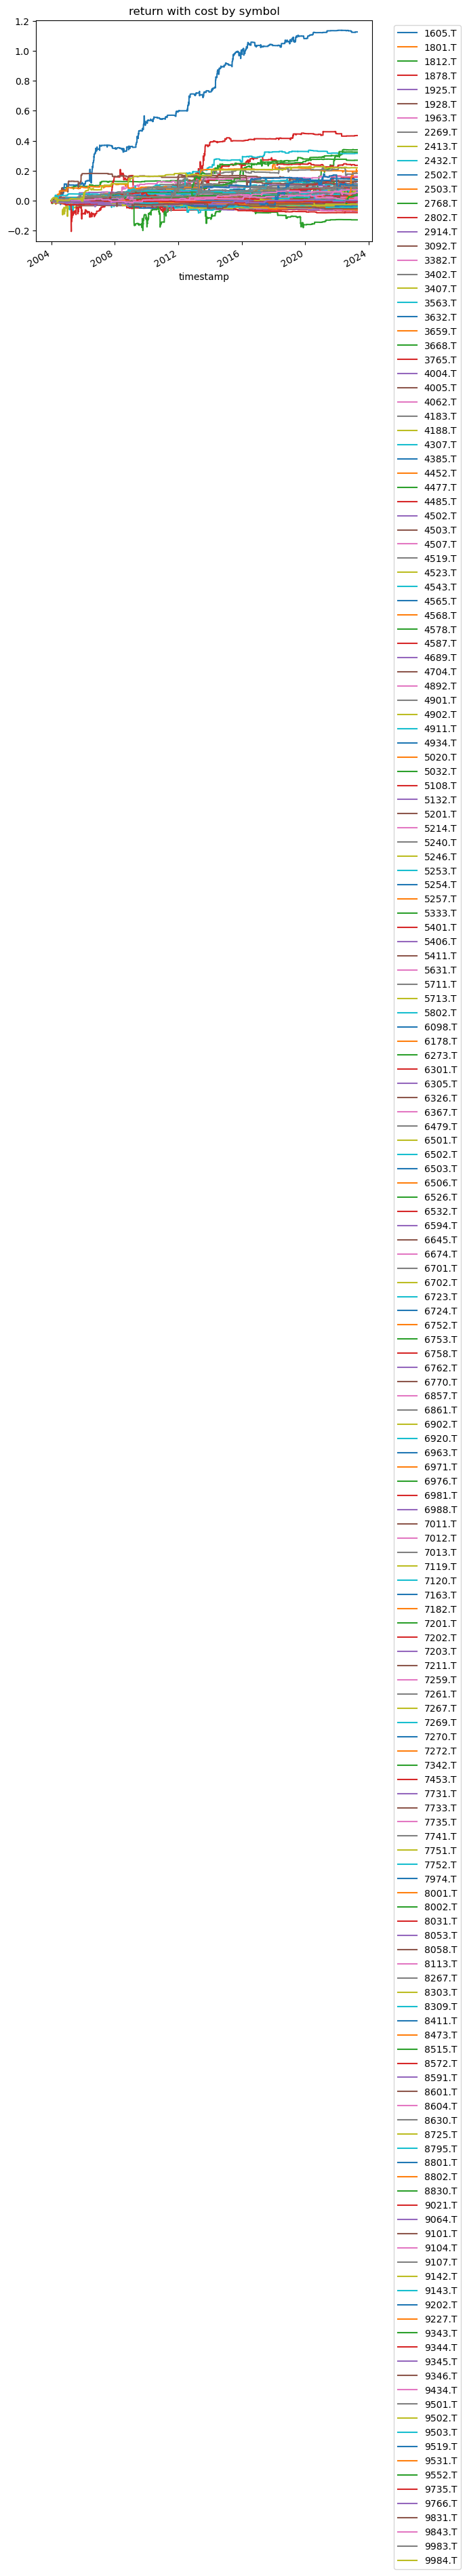

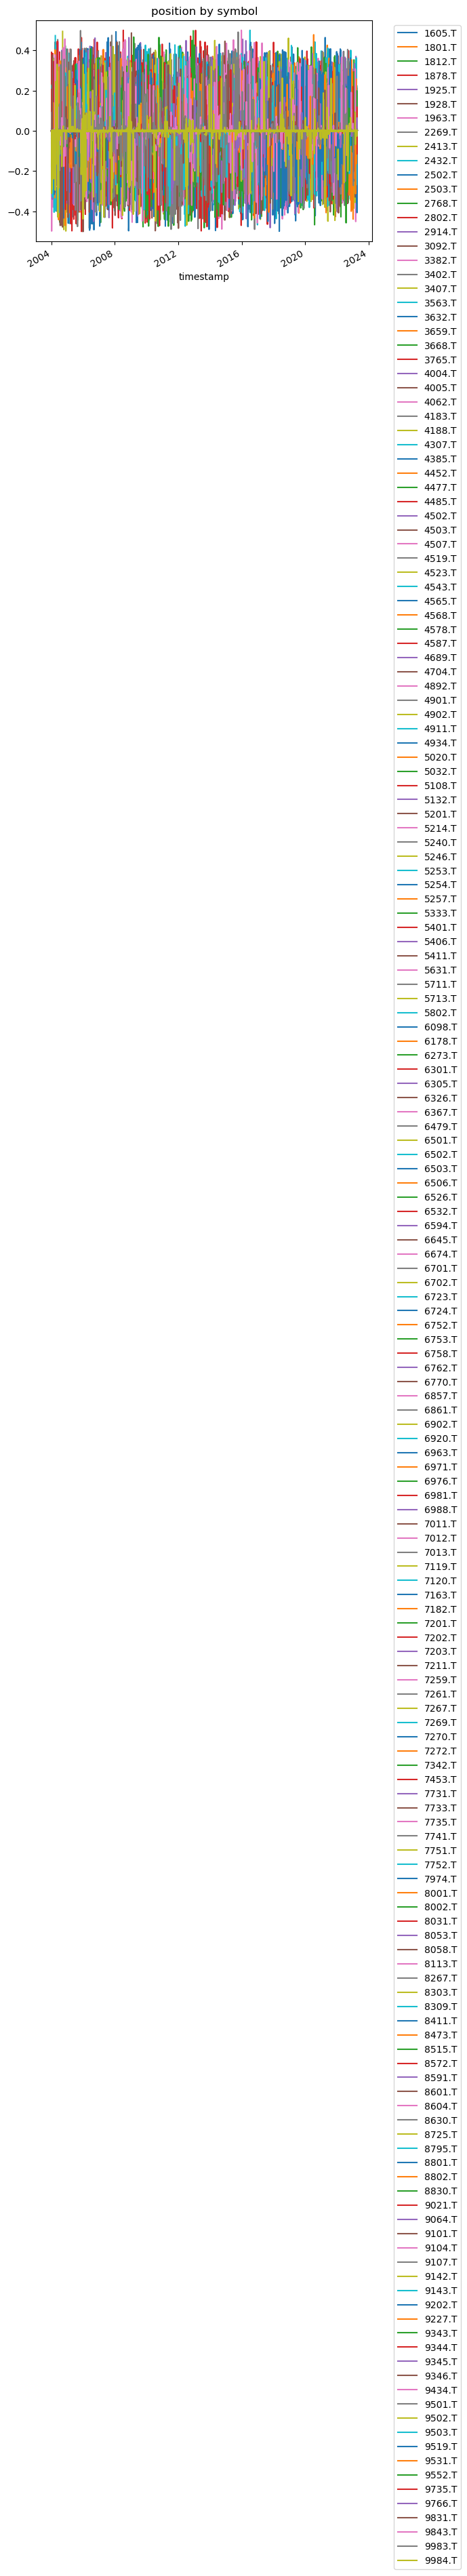

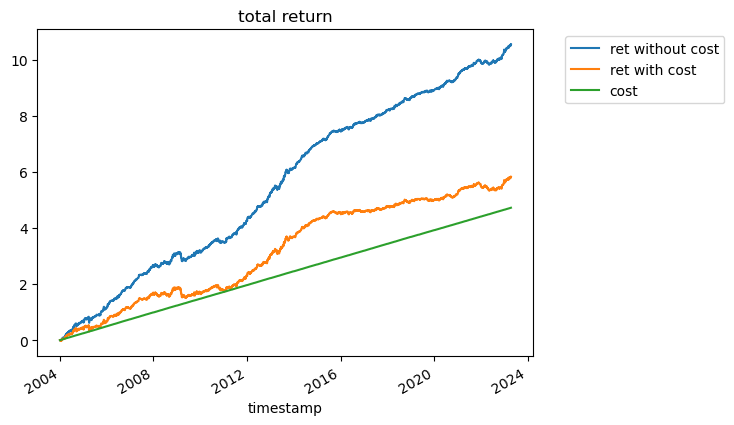

fit df.shape (695956, 401)
model size 13444276
position_op    0.0
position_cl    0.0
dtype: float64


In [50]:
df = pd.read_pickle('/tmp/df_stock.pkl')
df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2004-01-01 00:00:00Z')]
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2023-04-15 00:00:00Z')]

horizon = 1
# horizon = 5

df = df.loc[df['industry_code'] != 0]
# df = df.loc[~df['symbol_name'].str.contains('インバース')]
# df = df.loc[~df['symbol_name'].str.contains('ベア')]

df['amount'] = df['cl'] * df['volume']
amount = df.groupby('symbol')['amount'].mean()
df = df.loc[df.index.get_level_values('symbol').isin(amount.loc[amount > amount.quantile(0.95)].index)]

# price = df.groupby('symbol')['cl'].mean()
# df = df.loc[df.index.get_level_values('symbol').isin(price.loc[price < 10000].index)]

df['adj_op'] = df['op'] * df['adj_cl'] / df['cl']
# df['ret'] = df.groupby('symbol')['adj_op'].transform(lambda x: x.shift(-horizon - 1) / x.shift(-1) - 1).fillna(0)
df['ret'] = (df['cl'] / df['op'] - 1).groupby('symbol').shift(-1).fillna(0)
df['ret_night'] = (df.groupby('symbol')['adj_op'].shift(-2) / df.groupby('symbol')['adj_cl'].shift(-1) - 1).fillna(0)
display(df[['ret', 'ret_night']].describe())
df = df.loc[(-0.5 < df['ret']) & (df['ret'] < 0.5)]
df = df.loc[(-0.5 < df['ret_night']) & (df['ret_night'] < 0.5)]

# display(df.loc[df['ret_night'] > 0.7])

df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv_stock(model, df)
visualize_result_stock(df_cv.dropna(), execution_cost=0.0005)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)
print('model size {}'.format(os.path.getsize('/home/jovyan/data/{}.xz'.format(model_name))))

# validate cloudpickle
res1 = model.predict(df.iloc[-2 * 24 * 30 * 30:])
res2 = joblib.load('/home/jovyan/data/{}.xz'.format(model_name)).predict(df.iloc[-2 * 24 * 30 * 30:])
print((res1 - res2).abs().mean())

market_idx 0


100%|██████████| 4724/4724 [00:02<00:00, 1889.72it/s]


return without cost statistics
mean 0.002278296702916264
std 0.012742014430773869
sharpe 0.17880192455392585
double sharpe 4.13176211395788
max drawdown 0.35642139023907893
min -0.0778329640076565
min sharpe 0.029271616878063973
return with cost statistics
mean 0.0014879755731920517
std 0.012740794350642326
sharpe 0.11678828903764824
double sharpe 2.5899748342051256
max drawdown 0.39435763502218935
min -0.07865694253197904
min sharpe 0.01891728212785661


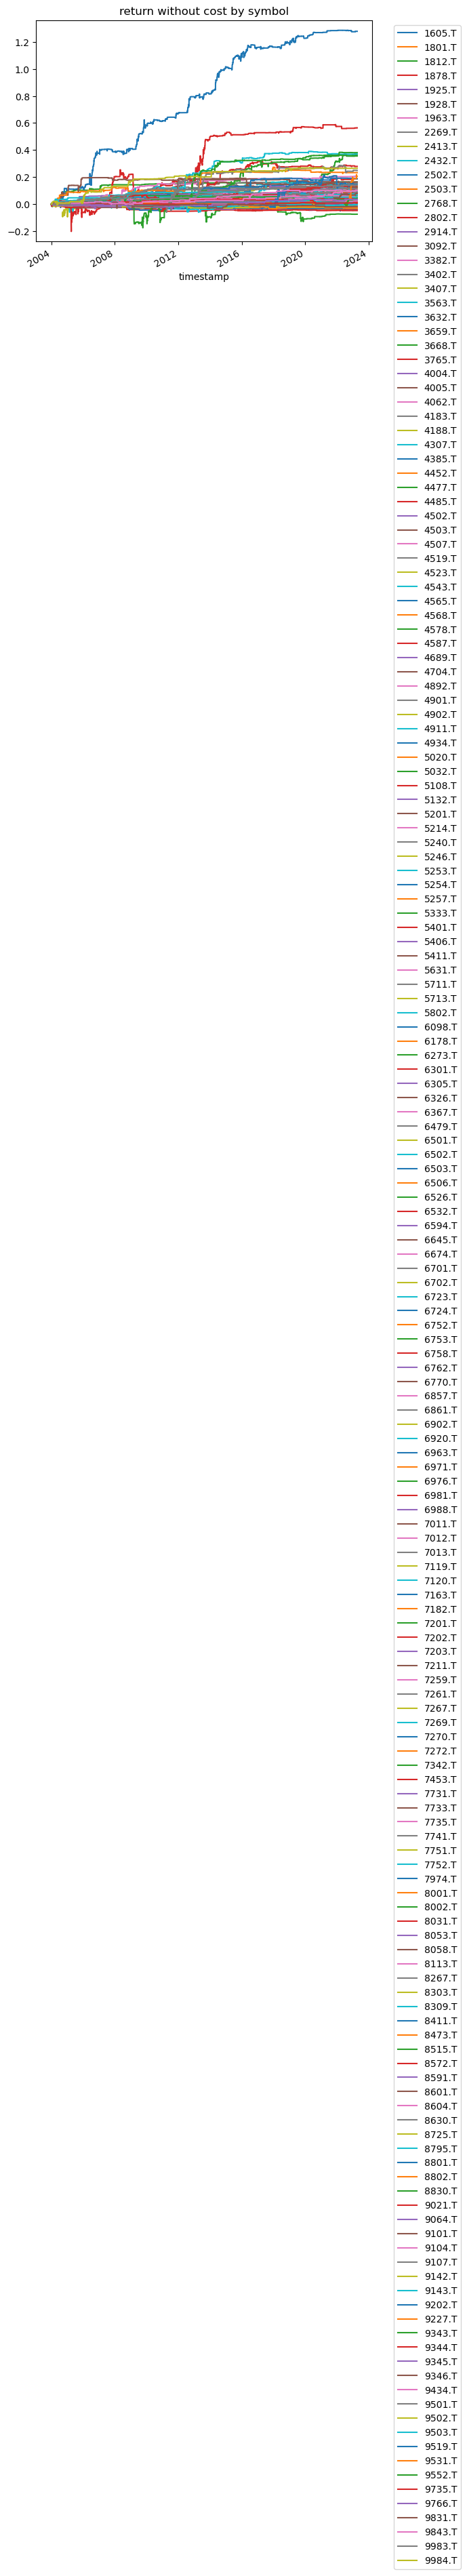

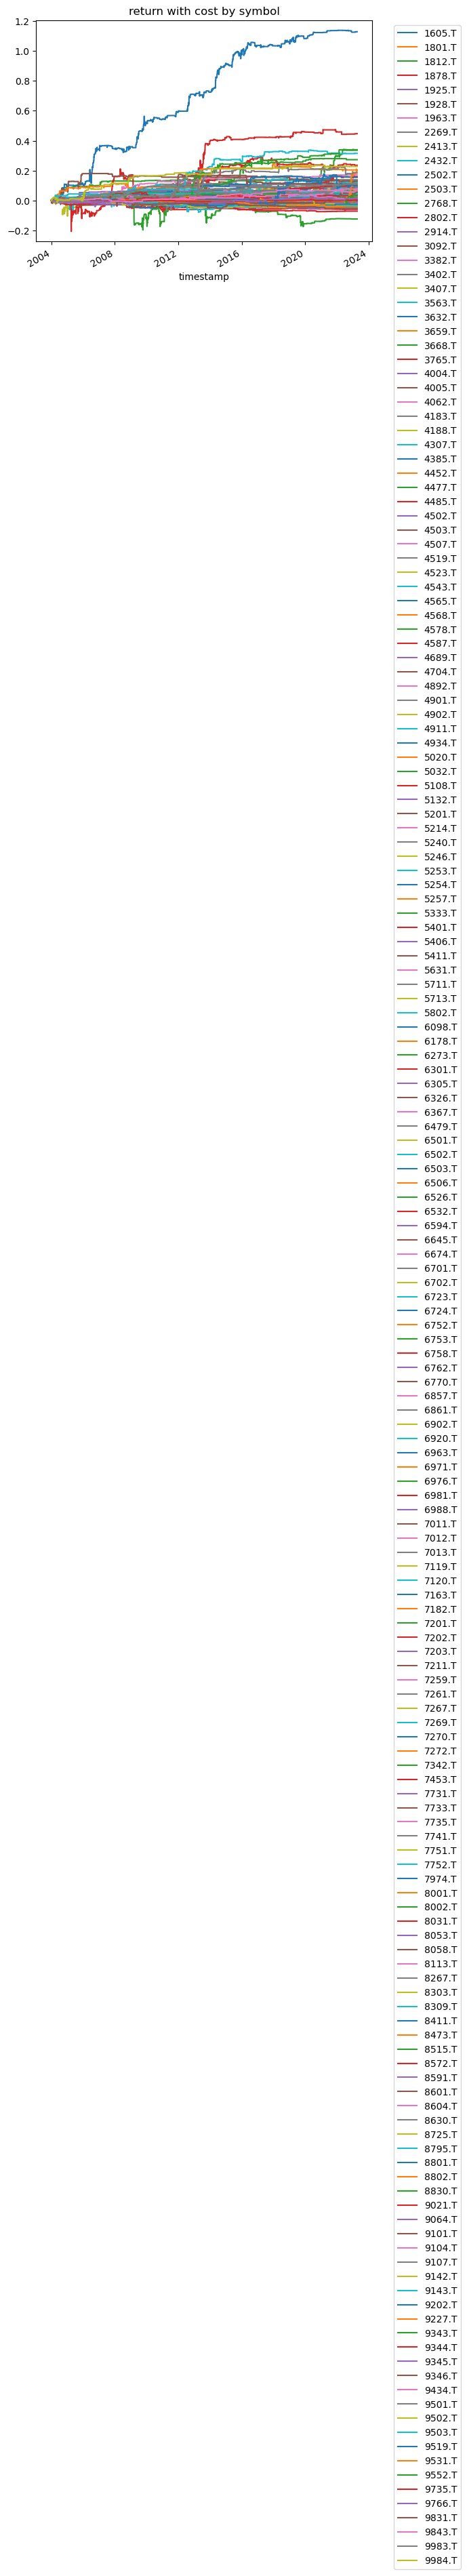

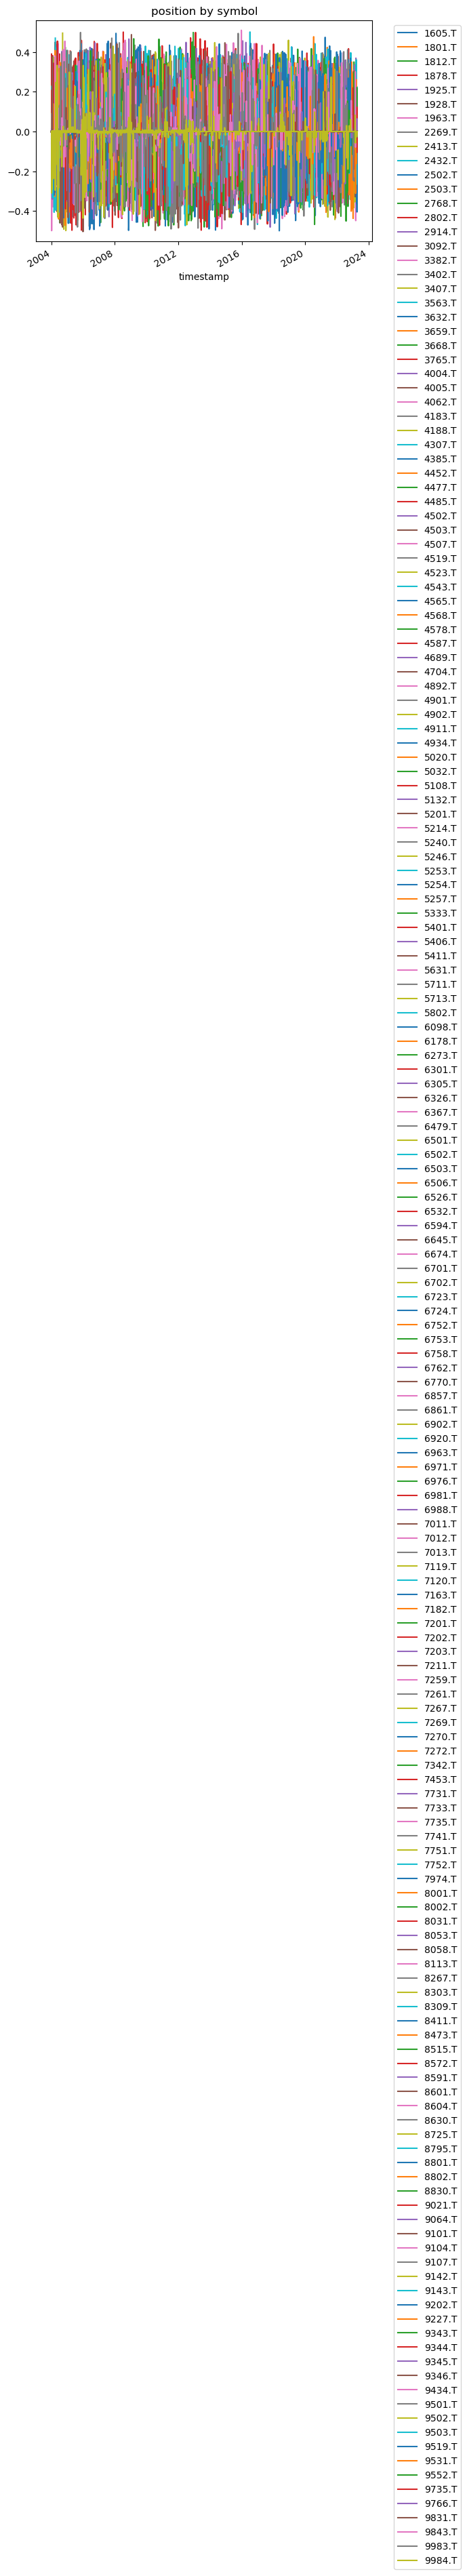

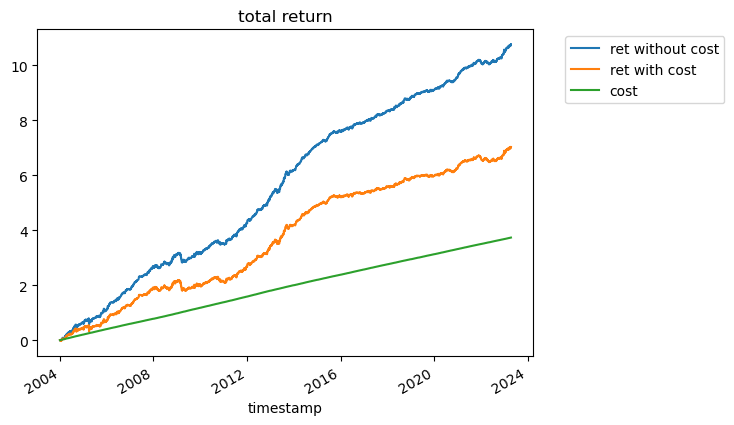

In [51]:
import cvxpy as cp
import numpy as np
from sklearn.covariance import ledoit_wolf
from tqdm import tqdm

# minimize distance
def approximate_portfolio2(target_weight, cov, unit_weight, nonnegative):
    n = target_weight.shape[0]
    coef = np.dot(target_weight, cov)
    # print(coef)
    
    x_pos = cp.Variable(n, integer=True)
    x_neg = cp.Variable(n, integer=True)
    
    w = cp.multiply(x_pos - x_neg, unit_weight)
    objective = cp.Minimize(target_weight.T @ cov @ target_weight - 2 * coef.T @ w + cp.quad_form(w, cov))
    constraints = [
        x_pos >= 0,
        x_neg >= 0,
        unit_weight.T @ (x_pos + x_neg) <= 1,
    ]
    if np.any(nonnegative):
        constraints += [x_neg[nonnegative] == 0]
    prob = cp.Problem(objective, constraints)
    # print(prob)
    prob.solve(solver='ECOS_BB')
    # prob.solve(solver='SCIP') # too slow
    
    print('optimum', prob.value)
    # print('x_pos', x_pos.value)
    # print('x_neg', x_neg.value)
    
    if x_pos.value is None or x_neg.value is None:
        return np.zeros(n)

    return (x_pos.value - x_neg.value) * unit_weight

def approximate_portfolio_df(df, budget_yen):
    df = df.copy()
    
    df_x = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='adj_cl'
    )
    df_x = (df_x / df_x.shift(1) - 1).fillna(0)
    
    df_op = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='position_op'
    ).fillna(0)
    df_cl = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='position_cl'
    ).fillna(0)
    
    df_price = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='cl'
    ).fillna(budget_yen)
    
    cov_len = 2 * 12 * 30
    
    df_op.iloc[:cov_len, :] = 0.0
    df_cl.iloc[:cov_len, :] = 0.0
    
    for i in tqdm(range(df_x.shape[0] - 12 * 30, df_x.shape[0])):
        print(df_x.index[i])
        
        df_cov = df_x.iloc[max(0, i - cov_len + 1):i + 1]
        cov, _ = ledoit_wolf(df_cov)
        
        # print(cov)

        weight = approximate_portfolio2(df_op.iloc[i].values, cov, np.maximum(0.01, 100 * df_price.iloc[i].values / budget_yen), np.array([False] * df_x.shape[1]))
        df_op.iloc[i, :] = weight
        weight = approximate_portfolio2(df_cl.iloc[i].values, cov, np.maximum(0.01, 100 * df_price.iloc[i].values / budget_yen), np.array([False] * df_x.shape[1]))
        df_cl.iloc[i, :] = weight
        
        # break

    df['position_op'] = df_op.stack().loc[df.index].fillna(0)
    df['position_cl'] = df_cl.stack().loc[df.index].fillna(0)
    
    return df


def approximate_portfolio_simple(target_weight, unit_weight, nonnegative, market_idx):
    w = np.round(target_weight / unit_weight) * unit_weight
    w[nonnegative & (w < 0)] = 0.0
    
    err = target_weight - w
    # w[market_idx] += np.sum(err)
    w = np.round(w / unit_weight) * unit_weight
    # w /= 1e-7 + np.sum(np.abs(w))
    return w

def approximate_portfolio_df_simple(df, budget_yen):
    df = df.copy()
    
    df_op = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='position_op'
    ).fillna(0)
    df_cl = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='position_cl'
    ).fillna(0)
    
    df_price = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='cl'
    ).fillna(budget_yen)
    
    market_idx = np.argmax(df_price.columns.values == '1306.T')
    print('market_idx', market_idx)
    
    for i in tqdm(range(df_price.shape[0])):
        weight = approximate_portfolio_simple(df_op.iloc[i].values, 100 * df_price.iloc[i].values / budget_yen, np.array([False] * df_price.shape[1]), market_idx)
        df_op.iloc[i, :] = weight
        weight = approximate_portfolio_simple(df_cl.iloc[i].values, 100 * df_price.iloc[i].values / budget_yen, np.array([False] * df_price.shape[1]), market_idx)
        df_cl.iloc[i, :] = weight

    df['position_op'] = df_op.stack().loc[df.index].fillna(0)
    df['position_cl'] = df_cl.stack().loc[df.index].fillna(0)
    
    return df

# df_approx = approximate_portfolio_df(df_cv, 1000 * 10000)
# df_approx = approximate_portfolio_df_simple(df_cv, 1000 * 10000)
df_approx = approximate_portfolio_df_simple(df_cv, 2000 * 10000)
visualize_result_stock(df_approx.dropna(), execution_cost=0.0005)

In [52]:
display(df_approx.iloc[-100:])

op       hi       lo       cl   adj_cl  \
timestamp                 symbol                                                
2023-04-14 00:00:00+00:00 6502.T   4429.0   4434.0   4424.0   4430.0   4430.0   
                          6503.T   1565.5   1593.0   1547.5   1579.5   1579.5   
                          6506.T   5650.0   5650.0   5550.0   5560.0   5560.0   
                          6526.T   9650.0   9760.0   9480.0   9740.0   9740.0   
                          6532.T   5190.0   5200.0   5110.0   5170.0   5170.0   
...                                   ...      ...      ...      ...      ...   
                          9766.T   6520.0   6520.0   6370.0   6450.0   6450.0   
                          9831.T    473.0    473.0    469.0    469.0    469.0   
                          9843.T  16685.0  16900.0  16650.0  16845.0  16845.0   
                          9983.T  32370.0  33220.0  31980.0  32840.0  32840.0   
                          9984.T   5228.0   5229.0   5091.0   5120.0   5120.0   

                                      volume  dividends  splits  \
timestamp                 symbol                                  
2023-04-14 00:00:00+00:00 6502.T   2769500.0        0.0     0.0   
                          6503.T   8147500.0        0.0     0.0   
                          6506.T   1477400.0        0.0     0.0   
                          6526.T    555900.0        0.0     0.0   
                          6532.T   1558200.0        0.0     0.0   
...                                      ...        ...     ...   
                          9766.T    655300.0        0.0     0.0   
                          9831.T   2805200.0        0.0     0.0   
                          9843.T    306000.0        0.0     0.0   
                          9983.T   4792700.0        0.0     0.0   
                          9984.T  11312800.0        0.0     0.0   

                                  capital_gains      symbol_name  \
timestamp                 symbol                                   
2023-04-14 00:00:00+00:00 6502.T            0.0               東芝   
                          6503.T            0.0             三菱電機   
                          6506.T            0.0             安川電機   
                          6526.T            0.0          ソシオネクスト   
                          6532.T            0.0  ベイカレント・コンサルティング   
...                                         ...              ...   
                          9766.T            0.0          コナミグループ   
                          9831.T            0.0      ヤマダホールディングス   
                          9843.T            0.0      ニトリホールディングス   
                          9983.T            0.0      ファーストリテイリング   
                          9984.T            0.0       ソフトバンクグループ   

                                  industry_code        amount   adj_op  ret  \
timestamp                 symbol                                              
2023-04-14 00:00:00+00:00 6502.T           3650  1.226888e+10   4429.0  0.0   
                          6503.T           3650  1.286898e+10   1565.5  0.0   
                          6506.T           3650  8.214344e+09   5650.0  0.0   
                          6526.T           3650  5.414466e+09   9650.0  0.0   
                          6532.T           9050  8.055894e+09   5190.0  0.0   
...                                         ...           ...      ...  ...   
                          9766.T           5250  4.226685e+09   6520.0  0.0   
                          9831.T           6100  1.315639e+09    473.0  0.0   
                          9843.T           6100  5.154570e+09  16685.0  0.0   
                          9983.T           6100  1.573923e+11  32370.0  0.0   
                          9984.T           5250  5.792154e+10   5228.0  0.0   

                                  ret_night        execution_start_at  \
timestamp                 symbol                                        
2023-04-14 00:00:00+00:00 6502.T        0.0 2023-04-14

In [ ]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_stock.pkl')
# df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)

print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()